This notebook roughly contains the same analysis as performed in CalibrationV6.ipynb, but this time for the nonlinear PXD032235 subset mzML file.

In [ ]:
from pyteomics import mzml

data = "20210120_HM_HEK_IAA_300minGr_R1.mzML"
spectra = []

# Open the linear mzML file for reading
with mzml.read(data) as reader:
    # Iterate over each spectrum in the linear mzML file
    for spectrum in reader:
        # Append the spectrum to the list
        spectra.append(spectrum)

# Print the number of spectra read
print("Number of spectra read (linear):", len(spectra))

Number of spectra read (linear): 89175


In [3]:
from psims.transform.mzml import MzMLTransformer

slope = -1.1812981416629081e-05
intercept = 0.001291879168543407

def calibrate_ms2(spectrum):
    retention_time = spectrum['scanList']['scan'][0]['scan start time']
    mz_values = spectrum['m/z array']
    
    # Apply the calibration function to the m/z values
    calibrated_mz_values = mz_values + (retention_time * slope + intercept)
    
    # Replace the original m/z values with the calibrated ones
    spectrum['m/z array'] = calibrated_mz_values   
    
    # If there are selected ions, calibrate their m/z values as well
    if 'precursorList' in spectrum and 'precursor' in spectrum['precursorList'] \
            and spectrum['precursorList']['precursor'] \
            and 'selectedIonList' in spectrum['precursorList']['precursor'][0] \
            and spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']:
        
        selected_ion_list = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']
        for selected_ion in selected_ion_list:
            selected_ion_mz = selected_ion.get('selected ion m/z')
            if selected_ion_mz is not None:
                selected_ion_mz_calibrated = selected_ion_mz + (retention_time * slope + intercept)
                selected_ion['selected ion m/z'] = selected_ion_mz_calibrated
    
    return spectrum

with open("20210120_HM_HEK_IAA_300minGr_R1.mzML", 'rb') as in_stream, \
        open("20210120_HM_HEK_IAA_300minGr_R1_LINcal_SelectedIonMZ.mzML", 'wb') as out_stream:
    MzMLTransformer(in_stream, out_stream, calibrate_ms2).write()

Handled 0 spectra
Handled 1000 spectra
Handled 2000 spectra
Handled 3000 spectra
Handled 4000 spectra
Handled 5000 spectra
Handled 6000 spectra
Handled 7000 spectra
Handled 8000 spectra
Handled 9000 spectra
Handled 10000 spectra
Handled 11000 spectra
Handled 12000 spectra
Handled 13000 spectra
Handled 14000 spectra
Handled 15000 spectra
Handled 16000 spectra
Handled 17000 spectra
Handled 18000 spectra
Handled 19000 spectra
Handled 20000 spectra
Handled 21000 spectra
Handled 22000 spectra
Handled 23000 spectra
Handled 24000 spectra
Handled 25000 spectra
Handled 26000 spectra
Handled 27000 spectra
Handled 28000 spectra
Handled 29000 spectra
Handled 30000 spectra
Handled 31000 spectra
Handled 32000 spectra
Handled 33000 spectra
Handled 34000 spectra
Handled 35000 spectra
Handled 36000 spectra
Handled 37000 spectra
Handled 38000 spectra
Handled 39000 spectra
Handled 40000 spectra
Handled 41000 spectra
Handled 42000 spectra
Handled 43000 spectra
Handled 44000 spectra
Handled 45000 spectra
H

In [2]:
import pandas as pd

Uncal = "20210120_HM_HEK_IAA_300minGr_R1.tsv"
df_Uncal = pd.read_csv(Uncal, sep='\t')
print("Shape of df_Uncal:", df_Uncal.shape)

Shape of df_Uncal: (60108, 36)


In [3]:
df_Uncal_filtered = df_Uncal[df_Uncal["spectrum_q"] < 0.01]
print("Shape of filtered DataFrame (df_Uncal):", df_Uncal_filtered.shape)

Shape of filtered DataFrame (df_Uncal): (46806, 36)


In [4]:
df_Uncal_filtered['exp_m/z'] = df_Uncal_filtered['expmass'] / df_Uncal_filtered['charge']
df_Uncal_filtered['calc_m/z'] = df_Uncal_filtered['calcmass'] / df_Uncal_filtered['charge']
df_Uncal_filtered['m/z_difference'] = df_Uncal_filtered['calc_m/z'] - df_Uncal_filtered['exp_m/z']

/tmp/ipykernel_1477869/304695436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Uncal_filtered['exp_m/z'] = df_Uncal_filtered['expmass'] / df_Uncal_filtered['charge']
/tmp/ipykernel_1477869/304695436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Uncal_filtered['calc_m/z'] = df_Uncal_filtered['calcmass'] / df_Uncal_filtered['charge']
/tmp/ipykernel_1477869/304695436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [5]:
# Create an empty DataFrame df_uncal_features
df_uncal_features_columns = ['m/z value', 'Retention time', 'Total ion count', 'Injection time', 'm/z error']
df_uncal_features = pd.DataFrame(columns=df_uncal_features_columns)

for index, row in df_Uncal_filtered.iterrows():
    scannr_value = int(df_Uncal_filtered.loc[index, 'scannr'].split("scan=")[-1]) -1
    spec2analyze = spectra[scannr_value]
    total_ion_count = spec2analyze['total ion current']
    injection_time = spec2analyze['scanList']['scan'][0]['ion injection time']
    m_z_value = row['exp_m/z']
    retention_time = row['rt']
    m_z_error = row['m/z_difference']
    
    # Append extracted values as a new row to df3 using loc
    df_uncal_features.loc[len(df_uncal_features)] = [m_z_value, retention_time, total_ion_count, injection_time, m_z_error]
    
print(len(df_uncal_features))
df_uncal_features.head(5)

46806


,m/z value,Retention time,Total ion count,Injection time,m/z error
0,869.952350,106.39572,3987641.5,110.302,0.00045
1,752.641675,206.77390,151422590.0,5.189,-0.00110
2,752.640575,207.29668,27206810.0,18.045,0.00000
3,1072.995500,128.34155,2356752.0,120.000,0.00085
4,1185.129500,292.91214,48723524.0,52.502,-0.00070


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the dataset
data = df_uncal_features

# Split the dataset into features (X) and labels (y)
X = data.drop(columns=['m/z error'])  # Features
y = data['m/z error']  # Labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = rf_regressor.predict(X_test)

# Calculate and print the Mean Squared Error (MSE) of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 2.4907111804164468e-06


In [8]:
# Selecting only the first four columns of nonlin_df_q
nonlin_df_q_RF_subset = df_uncal_features[['m/z value', 'Retention time', 'Total ion count', 'Injection time']]

# Predict using the subset of data
nonlin_pred = rf_regressor.predict(nonlin_df_q_RF_subset)
print(len(nonlin_pred))


# Adding the predictions as a new column to nonlin_df_q
df_Uncal_filtered['m/z_difference_predicted_RF'] = nonlin_pred
df_Uncal_filtered['m/z_difference_adjusted_RF'] = df_Uncal_filtered['m/z_difference'] - df_Uncal_filtered['m/z_difference_predicted_RF']

46806


/tmp/ipykernel_1477869/499146742.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Uncal_filtered['m/z_difference_predicted_RF'] = nonlin_pred
/tmp/ipykernel_1477869/499146742.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Uncal_filtered['m/z_difference_adjusted_RF'] = df_Uncal_filtered['m/z_difference'] - df_Uncal_filtered['m/z_difference_predicted_RF']


In [9]:
# Create an empty list
dataV2 = []

# Iterate over spectra_list
for spectrum in spectra:
    m_z_values = spectrum['m/z array']
    retention_time = spectrum['scanList']['scan'][0]['scan start time']
    total_ion_count = spectrum['total ion current']
    injection_time = spectrum['scanList']['scan'][0]['ion injection time']
    
    # Iterate over each m/z value in the spectrum
    for m_z_value in m_z_values:
        # Append a dictionary for each m/z value along with the corresponding metadata
        dataV2.append({
            'm/z value': m_z_value,
            'Retention time': retention_time,
            'Total ion count': total_ion_count,
            'Injection time': injection_time
        })

In [10]:
# Convert the list to a DataFrame
df_uncal_features_WholeMZML = pd.DataFrame(dataV2)

print(len(df_uncal_features_WholeMZML))
df_uncal_features_WholeMZML.head(5)

63830554


,m/z value,Retention time,Total ion count,Injection time
0,300.064758,0.008503,25481468.0,303.462
1,300.082764,0.008503,25481468.0,303.462
2,300.293488,0.008503,25481468.0,303.462
3,300.301117,0.008503,25481468.0,303.462
4,300.858368,0.008503,25481468.0,303.462


In [35]:

import warnings
import numpy as np
from psims.transform.mzml import MzMLTransformer

# Suppress UserWarning about feature names
warnings.filterwarnings("ignore", category=UserWarning)

def get_x(spectrum):
    mz_values = spectrum['m/z array']
    retention_time = spectrum['scanList']['scan'][0]['scan start time']
    total_ion_count = spectrum['total ion current']
    injection_time = spectrum['scanList']['scan'][0]['ion injection time']
    x = [[mz_value, retention_time, total_ion_count, injection_time] for mz_value in mz_values]
    return x

def calibrate_ms(spectrum):
    mz_values = spectrum['m/z array']
    x = get_x(spectrum)
    
    # Apply the calibration function to the m/z values
    calibrated_mz_values = np.array(mz_values) + np.array(rf_regressor.predict(x))
    
    # Replace the original m/z values with the calibrated ones
    spectrum['m/z array'] = calibrated_mz_values   
    
    # If there are selected ions, calibrate their m/z values as well
    if 'precursorList' in spectrum and 'precursor' in spectrum['precursorList'] \
            and spectrum['precursorList']['precursor'] \
            and 'selectedIonList' in spectrum['precursorList']['precursor'][0] \
            and spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']:
        
        selected_ion_list = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon']
        for selected_ion in selected_ion_list:
            selected_ion_mz_str = selected_ion.get('selected ion m/z')
            if selected_ion_mz_str is not None:
                # Extract the numerical value from the string representation
                selected_ion_mz = float(spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['selected ion m/z'])
                
                # Create features for prediction for the selected ion
                x_selected_ion = np.array([[selected_ion_mz, retention_time, total_ion_count, injection_time]])
                
                # Calibrate the selected ion m/z value
                calibrated_selected_ion_mz = str(selected_ion_mz + rf_regressor.predict(x_selected_ion))[1:-1]
                selected_ion['selected ion m/z'] = calibrated_selected_ion_mz
    
    return spectrum

with open("20210120_HM_HEK_IAA_300minGr_R1.mzML", 'rb') as in_stream, open("20210120_HM_HEK_IAA_300minGr_R1_RFcal_SelectedIonMZ_V2.mzML", 'wb') as out_stream:
    MzMLTransformer(in_stream, out_stream, calibrate_ms).write()
    

Handled 0 spectra
Handled 1000 spectra
Handled 2000 spectra
Handled 3000 spectra
Handled 4000 spectra
Handled 5000 spectra
Handled 6000 spectra
Handled 7000 spectra
Handled 8000 spectra
Handled 9000 spectra
Handled 10000 spectra
Handled 11000 spectra
Handled 12000 spectra
Handled 13000 spectra
Handled 14000 spectra
Handled 15000 spectra
Handled 16000 spectra
Handled 17000 spectra
Handled 18000 spectra
Handled 19000 spectra
Handled 20000 spectra
Handled 21000 spectra
Handled 22000 spectra
Handled 23000 spectra
Handled 24000 spectra
Handled 25000 spectra
Handled 26000 spectra
Handled 27000 spectra
Handled 28000 spectra
Handled 29000 spectra
Handled 30000 spectra
Handled 31000 spectra
Handled 32000 spectra
Handled 33000 spectra
Handled 34000 spectra
Handled 35000 spectra
Handled 36000 spectra
Handled 37000 spectra
Handled 38000 spectra
Handled 39000 spectra
Handled 40000 spectra
Handled 41000 spectra
Handled 42000 spectra
Handled 43000 spectra
Handled 44000 spectra
Handled 45000 spectra
H

In [42]:
import numpy as np
selected_ion_mz = float(spectra[16785]['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['selected ion m/z'])

x_selected_ion = np.array([[selected_ion_mz, retention_time, total_ion_count, injection_time]])
x_selected_ion

predic = rf_regressor.predict(x_selected_ion)
predic

calibrated_selected_ion_mz = selected_ion_mz + rf_regressor.predict(x_selected_ion)  # Assuming a single prediction for simplicity
print(selected_ion_mz)
print(str(calibrated_selected_ion_mz)[1:-1])

871.406860351563
871.40536185


In [3]:
import pandas as pd

Uncal = "20210120_HM_HEK_IAA_300minGr_R1.tsv"
LINcal_original = "20210120_HM_HEK_IAA_300minGr_R1_Calibrated_LIN.tsv"
LINcal_selectedIonMZ = "20210120_HM_HEK_IAA_300minGr_R1_LINcal_SelectedIonMZ.tsv"
RFcal_original = "20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RF.tsv"
RFcal_selectedIonMZ = "20210120_HM_HEK_IAA_300minGr_R1_RFcal_SelectedIonMZ.tsv"

df_Uncal = pd.read_csv(Uncal, sep='\t')
df_LINcal_original = pd.read_csv(LINcal_original, sep='\t')
df_LINcal_selectedIonMZ = pd.read_csv(LINcal_selectedIonMZ, sep='\t')
df_RFcal_original = pd.read_csv(RFcal_original, sep='\t')
df_RFcal_selectedIonMZ = pd.read_csv(RFcal_selectedIonMZ, sep='\t')

print("Shape of df_Uncal:", df_Uncal.shape)
print("Shape of df_original:", df_LINcal_original.shape)
print("Shape of df_selectedIonMZ:", df_LINcal_selectedIonMZ.shape)
print("Shape of df_RFcal_original:", df_RFcal_original.shape)
print("Shape of df_RFcal_selectedIonMZ:", df_RFcal_selectedIonMZ.shape)

Shape of df_Uncal: (60108, 36)
Shape of df_original: (57078, 36)
Shape of df_selectedIonMZ: (57056, 36)
Shape of df_RFcal_original: (55871, 36)
Shape of df_RFcal_selectedIonMZ: (55854, 36)


In [4]:
# Filtering both dataframes
df_Uncal_filtered = df_Uncal[df_Uncal["spectrum_q"] < 0.01]
df_LINcal_original_filtered = df_LINcal_original[df_LINcal_original["spectrum_q"] < 0.01]
df_LINcal_selectedIonMZ_filtered = df_LINcal_selectedIonMZ[df_LINcal_selectedIonMZ["spectrum_q"] < 0.01]
df_RFcal_original_filtered = df_RFcal_original[df_RFcal_original["spectrum_q"] < 0.01]
df_RFcal_selectedIonMZ_filtered = df_RFcal_selectedIonMZ[df_RFcal_selectedIonMZ["spectrum_q"] < 0.01]

print("Shape of filtered DataFrame (df_Uncal):", df_Uncal_filtered.shape)
print("Shape of filtered DataFrame (df_LINcal_original):", df_LINcal_original_filtered.shape)
print("Shape of filtered DataFrame (df_LINcal_selectedIonMZ):", df_LINcal_selectedIonMZ_filtered.shape)
print("Shape of filtered DataFrame (df_RFcal_original):", df_RFcal_original_filtered.shape)
print("Shape of filtered DataFrame (df_RFcal_selectedIonMZ):", df_RFcal_selectedIonMZ_filtered.shape)


Shape of filtered DataFrame (df_Uncal): (46806, 36)
Shape of filtered DataFrame (df_LINcal_original): (46170, 36)
Shape of filtered DataFrame (df_LINcal_selectedIonMZ): (46081, 36)
Shape of filtered DataFrame (df_RFcal_original): (44809, 36)
Shape of filtered DataFrame (df_RFcal_selectedIonMZ): (44844, 36)


In [5]:
df_Uncal_filtered['exp_m/z'] = df_Uncal_filtered['expmass'] / df_Uncal_filtered['charge']
df_Uncal_filtered['calc_m/z'] = df_Uncal_filtered['calcmass'] / df_Uncal_filtered['charge']
df_Uncal_filtered['m/z_difference'] = df_Uncal_filtered['calc_m/z'] - df_Uncal_filtered['exp_m/z']

df_LINcal_original_filtered['exp_m/z'] = df_LINcal_original_filtered['expmass'] / df_LINcal_original_filtered['charge']
df_LINcal_original_filtered['calc_m/z'] = df_LINcal_original_filtered['calcmass'] / df_LINcal_original_filtered['charge']
df_LINcal_original_filtered['m/z_difference'] = df_LINcal_original_filtered['calc_m/z'] - df_LINcal_original_filtered['exp_m/z']

df_LINcal_selectedIonMZ_filtered['exp_m/z'] = df_LINcal_selectedIonMZ_filtered['expmass'] / df_LINcal_selectedIonMZ_filtered['charge']
df_LINcal_selectedIonMZ_filtered['calc_m/z'] = df_LINcal_selectedIonMZ_filtered['calcmass'] / df_LINcal_selectedIonMZ_filtered['charge']
df_LINcal_selectedIonMZ_filtered['m/z_difference'] = df_LINcal_selectedIonMZ_filtered['calc_m/z'] - df_LINcal_selectedIonMZ_filtered['exp_m/z']

df_RFcal_original_filtered['exp_m/z'] = df_RFcal_original_filtered['expmass'] / df_RFcal_original_filtered['charge']
df_RFcal_original_filtered['calc_m/z'] = df_RFcal_original_filtered['calcmass'] / df_RFcal_original_filtered['charge']
df_RFcal_original_filtered['m/z_difference'] = df_RFcal_original_filtered['calc_m/z'] - df_RFcal_original_filtered['exp_m/z']

df_RFcal_selectedIonMZ_filtered['exp_m/z'] = df_RFcal_selectedIonMZ_filtered['expmass'] / df_RFcal_selectedIonMZ_filtered['charge']
df_RFcal_selectedIonMZ_filtered['calc_m/z'] = df_RFcal_selectedIonMZ_filtered['calcmass'] / df_RFcal_selectedIonMZ_filtered['charge']
df_RFcal_selectedIonMZ_filtered['m/z_difference'] = df_RFcal_selectedIonMZ_filtered['calc_m/z'] - df_RFcal_selectedIonMZ_filtered['exp_m/z']

/tmp/ipykernel_2501553/3309618538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Uncal_filtered['exp_m/z'] = df_Uncal_filtered['expmass'] / df_Uncal_filtered['charge']
/tmp/ipykernel_2501553/3309618538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Uncal_filtered['calc_m/z'] = df_Uncal_filtered['calcmass'] / df_Uncal_filtered['charge']
/tmp/ipykernel_2501553/3309618538.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [6]:
# Extract unique values of "scannr" column from each filtered dataframe
df_uncal_filtered_scannr = set(df_Uncal_filtered['scannr'])
df_calLIN_filtered_scannr = set(df_LINcal_selectedIonMZ_filtered['scannr'])
df_calRF_filtered_scannr = set(df_RFcal_selectedIonMZ_filtered['scannr'])

In [7]:
filtered_scannr_identified = df_uncal_filtered_scannr.union(df_calLIN_filtered_scannr).union(df_calRF_filtered_scannr)
print(len(filtered_scannr_identified))

47275


In [8]:
filtered_merged_data = df_Uncal_filtered.merge(df_LINcal_selectedIonMZ_filtered, on='scannr', how='outer', suffixes=('_uncal', ''))
filtered_merged_data = filtered_merged_data.merge(df_RFcal_selectedIonMZ_filtered, on='scannr', how='outer', suffixes=('_calLIN', '_calRF'))
print(filtered_merged_data.shape)
filtered_merged_data.head()

(47275, 115)


,peptide_uncal,proteins_uncal,num_proteins_uncal,filename_uncal,scannr,rank_uncal,label_uncal,expmass_uncal,calcmass_uncal,charge_uncal,...,sage_discriminant_score_calRF,posterior_error_calRF,spectrum_q_calRF,peptide_q_calRF,protein_q_calRF,ms1_intensity_calRF,ms2_intensity_calRF,exp_m/z_calRF,calc_m/z_calRF,m/z_difference_calRF
0,VM[+15.9949]LGETNPADSKPGTIR,tr|J3KPD9|J3KPD9_HUMAN,1.0,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=10000,1.0,1.0,1800.9109,1800.9039,3.0,...,1.79966,-186.767210,0.000113,0.000203,0.000394,7108269.0,739279.60,600.301667,600.30130,-0.000367
1,NaN,NaN,NaN,NaN,controllerType=0 controllerNumber=1 scan=10004,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LMIEM[+15.9949]DGTENK,tr|A4UCS8|A4UCS8_HUMAN,1.0,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=10007,1.0,1.0,1295.5801,1295.5737,2.0,...,0.98694,-1.865966,0.000866,0.000171,0.000536,1854185.2,131978.06,647.788150,647.78685,-0.001300
3,ALDVTDKEGEEREDADVSVTQR,tr|A0A8Q3SIW9|A0A8Q3SIW9_HUMAN;tr|A0A8Q3SIZ6|A...,3.0,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=10019,1.0,1.0,2461.1707,2461.1567,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,VFDKEGNGTVM[+15.9949]GAEIR,tr|F8VPF3|F8VPF3_HUMAN;tr|F8VZU9|F8VZU9_HUMAN;...,9.0,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=10020,1.0,1.0,1737.8472,1737.8356,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Selecting desired columns from the merged DataFrame
filtered_desired_columns = ['scannr', 
                   'peptide_uncal', 'proteins_uncal', 'precursor_ppm_uncal', 'fragment_ppm_uncal', 'charge_uncal', 'hyperscore_uncal',
                   'peptide_calLIN', 'proteins_calLIN', 'precursor_ppm_calLIN','fragment_ppm_calLIN', 'charge_calLIN', 'hyperscore_calLIN',
                   'peptide_calRF', 'proteins_calRF', 'precursor_ppm_calRF','fragment_ppm_calRF', 'charge_calRF', 'hyperscore_calRF']

# Selecting only the desired columns
filtered_desired_data = filtered_merged_data[filtered_desired_columns]
filtered_desired_data.head()

,scannr,peptide_uncal,proteins_uncal,precursor_ppm_uncal,fragment_ppm_uncal,charge_uncal,hyperscore_uncal,peptide_calLIN,proteins_calLIN,precursor_ppm_calLIN,fragment_ppm_calLIN,charge_calLIN,hyperscore_calLIN,peptide_calRF,proteins_calRF,precursor_ppm_calRF,fragment_ppm_calRF,charge_calRF,hyperscore_calRF
0,controllerType=0 controllerNumber=1 scan=10000,VM[+15.9949]LGETNPADSKPGTIR,tr|J3KPD9|J3KPD9_HUMAN,3.863612,3.923674,3.0,55.965058,VM[+15.9949]LGETNPADSKPGTIR,tr|J3KPD9|J3KPD9_HUMAN,4.541438,3.241472,3.0,55.965058,VM[+15.9949]LGETNPADSKPGTIR,tr|J3KPD9|J3KPD9_HUMAN,0.610045,8.134890,3.0,43.154898
1,controllerType=0 controllerNumber=1 scan=10004,NaN,NaN,NaN,NaN,NaN,NaN,FYEQM[+15.9949]NGPVAGASR,tr|B2RAR6|B2RAR6_HUMAN,4.671573,4.310357,2.0,24.284634,NaN,NaN,NaN,NaN,NaN,NaN
2,controllerType=0 controllerNumber=1 scan=10007,LMIEM[+15.9949]DGTENK,tr|A4UCS8|A4UCS8_HUMAN,4.899482,3.389514,2.0,38.181168,LMIEM[+15.9949]DGTENK,tr|A0A024R4F1|A0A024R4F1_HUMAN,5.464806,2.566633,2.0,38.181168,LMIEM[+15.9949]DGTENK,tr|A4UCS8|A4UCS8_HUMAN,1.978640,6.622154,2.0,20.251653
3,controllerType=0 controllerNumber=1 scan=10019,ALDVTDKEGEEREDADVSVTQR,tr|A0A8Q3SIW9|A0A8Q3SIW9_HUMAN;tr|A0A8Q3SIZ6|A...,5.654242,4.953127,4.0,29.560918,ALDVTDKEGEEREDADVSVTQR,tr|A0A8Q3SIW9|A0A8Q3SIW9_HUMAN;tr|A0A8Q3SIZ6|A...,6.249423,3.899175,4.0,29.560918,NaN,NaN,NaN,NaN,NaN,NaN
4,controllerType=0 controllerNumber=1 scan=10020,VFDKEGNGTVM[+15.9949]GAEIR,tr|F8VPF3|F8VPF3_HUMAN;tr|F8VZU9|F8VZU9_HUMAN;...,6.673037,4.355175,3.0,18.610127,VFDKEGNGTVM[+15.9949]GAELR,tr|A0A024R2Q5|A0A024R2Q5_HUMAN,7.375459,3.833401,3.0,18.610127,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_2501553/2758565545.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)
/tmp/ipykernel_2501553/2758565545.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)
/tmp/ipykernel_2501553/2758565545.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)


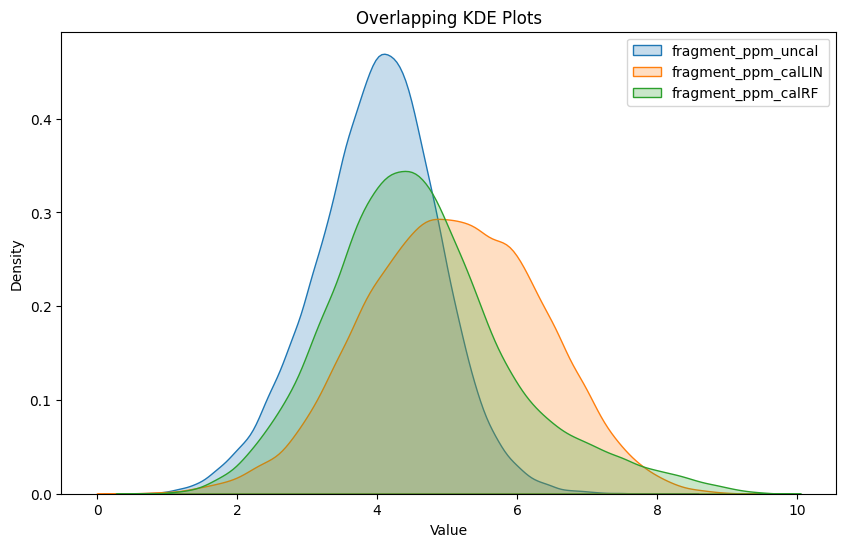

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 6))

columns_to_plot = ['fragment_ppm_uncal', 'fragment_ppm_calLIN', 'fragment_ppm_calRF']

# Loop through each column and create overlapping KDE plots
for column in columns_to_plot:
    sns.kdeplot(filtered_merged_data[column], label=column, shade=True)

# Set title and labels
plt.title('Overlapping KDE Plots')
plt.xlabel('Value')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()

/tmp/ipykernel_2501553/421050016.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)
/tmp/ipykernel_2501553/421050016.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)
/tmp/ipykernel_2501553/421050016.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)


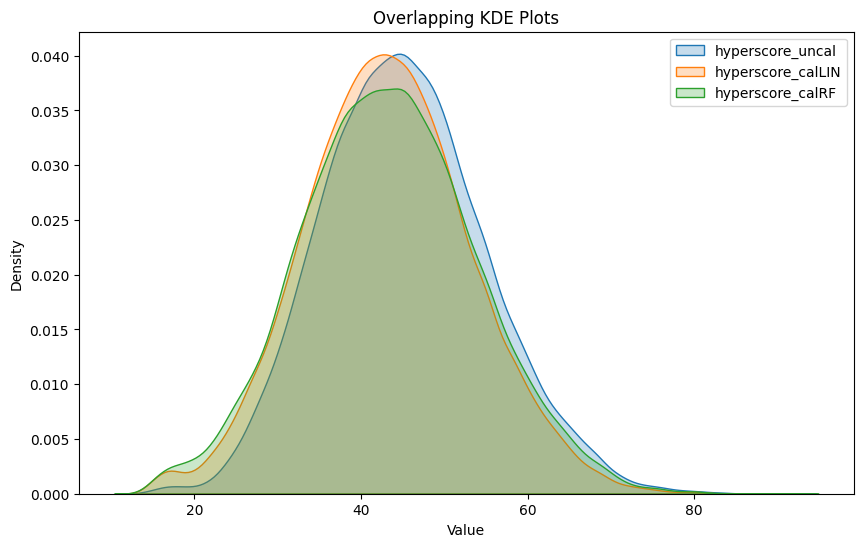

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 6))

columns_to_plot = ['hyperscore_uncal', 'hyperscore_calLIN', 'hyperscore_calRF']

# Loop through each column and create overlapping KDE plots
for column in columns_to_plot:
    sns.kdeplot(filtered_merged_data[column], label=column, shade=True)

# Set title and labels
plt.title('Overlapping KDE Plots')
plt.xlabel('Value')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()

In [14]:
pd.set_option('display.max_columns', None)
filtered_merged_data.head(5)


,peptide_uncal,proteins_uncal,num_proteins_uncal,filename_uncal,scannr,rank_uncal,label_uncal,expmass_uncal,calcmass_uncal,charge_uncal,peptide_len_uncal,missed_cleavages_uncal,isotope_error_uncal,precursor_ppm_uncal,fragment_ppm_uncal,hyperscore_uncal,delta_next_uncal,delta_best_uncal,rt_uncal,aligned_rt_uncal,predicted_rt_uncal,delta_rt_model_uncal,matched_peaks_uncal,longest_b_uncal,longest_y_uncal,longest_y_pct_uncal,matched_intensity_pct_uncal,scored_candidates_uncal,poisson_uncal,sage_discriminant_score_uncal,posterior_error_uncal,spectrum_q_uncal,peptide_q_uncal,protein_q_uncal,ms1_intensity_uncal,ms2_intensity_uncal,exp_m/z_uncal,calc_m/z_uncal,m/z_difference_uncal,peptide_calLIN,proteins_calLIN,num_proteins_calLIN,filename_calLIN,rank_calLIN,label_calLIN,expmass_calLIN,calcmass_calLIN,charge_calLIN,peptide_len_calLIN,missed_cleavages_calLIN,isotope_error_calLIN,precursor_ppm_calLIN,fragment_ppm_calLIN,hyperscore_calLIN,delta_next_calLIN,delta_best_calLIN,rt_calLIN,aligned_rt_calLIN,predicted_rt_calLIN,delta_rt_model_calLIN,matched_peaks_calLIN,longest_b_calLIN,longest_y_calLIN,longest_y_pct_calLIN,matched_intensity_pct_calLIN,scored_candidates_calLIN,poisson_calLIN,sage_discriminant_score_calLIN,posterior_error_calLIN,spectrum_q_calLIN,peptide_q_calLIN,protein_q_calLIN,ms1_intensity_calLIN,ms2_intensity_calLIN,exp_m/z_calLIN,calc_m/z_calLIN,m/z_difference_calLIN,peptide_calRF,proteins_calRF,num_proteins_calRF,filename_calRF,rank_calRF,label_calRF,expmass_calRF,calcmass_calRF,charge_calRF,peptide_len_calRF,missed_cleavages_calRF,isotope_error_calRF,precursor_ppm_calRF,fragment_ppm_calRF,hyperscore_calRF,delta_next_calRF,delta_best_calRF,rt_calRF,aligned_rt_calRF,predicted_rt_calRF,delta_rt_model_calRF,matched_peaks_calRF,longest_b_calRF,longest_y_calRF,longest_y_pct_calRF,matched_intensity_pct_calRF,scored_candidates_calRF,poisson_calRF,sage_discriminant_score_calRF,posterior_error_calRF,spectrum_q_calRF,peptide_q_calRF,protein_q_calRF,ms1_intensity_calRF,ms2_intensity_calRF,exp_m/z_calRF,calc_m/z_calRF,m/z_difference_calRF
0,VM[+15.9949]LGETNPADSKPGTIR,tr|J3KPD9|J3KPD9_HUMAN,1.0,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=10000,1.0,1.0,1800.9109,1800.9039,3.0,17.0,0.0,0.0,3.863612,3.923674,55.965058,31.037002,0.0,76.17888,0.256495,0.296122,0.039627,18.0,2.0,12.0,0.705882,44.044384,59.0,-13.714402,2.390571,-281.391080,0.000121,0.000225,0.000431,7108269.0,1029485.560,600.303633,600.301300,-0.002333,VM[+15.9949]LGETNPADSKPGTIR,tr|J3KPD9|J3KPD9_HUMAN,1.0,20210120_HM_HEK_IAA_300minGr_R1_LINcal_Selecte...,1.0,1.0,1800.9121,1800.9039,3.0,17.0,0.0,0.0,4.541438,3.241472,55.965058,31.037002,0.0,76.17888,0.256495,0.295094,0.038599,18.0,2.0,12.0,0.705882,44.044384,60.0,-13.756427,1.987086,-162.151860,0.000125,0.000232,0.000440,7108269.00,1029485.560,600.304033,600.301300,-0.002733,VM[+15.9949]LGETNPADSKPGTIR,tr|J3KPD9|J3KPD9_HUMAN,1.0,20210120_HM_HEK_IAA_300minGr_R1_RFcal_Selected...,1.0,1.0,1800.9050,1800.9039,3.0,17.0,0.0,0.0,0.610045,8.134890,43.154898,43.154898,0.0,76.17888,0.256495,0.303795,0.047301,13.0,1.0,11.0,0.647059,31.628525,47.0,-8.965869,1.79966,-186.767210,0.000113,0.000203,0.000394,7108269.0,739279.60,600.301667,600.30130,-0.000367
1,NaN,NaN,NaN,NaN,controllerType=0 controllerNumber=1 scan=10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FYEQM[+15.9949]NGPVAGASR,tr|B2RAR6|B2RAR6_HUMAN,1.0,20210120_HM_HEK_IAA_300minGr_R1_LINcal_Selecte...,1.0,1.0,1541.7003,1541.6931,2.0,14.0,0.0,0.0,4.671573,4.310357,24.284634,24.284634,0.0,76.20530,0.256584,0.385653,0.129070,6.0,1.0,2.0,0.142857,40.261100,3.0,-2.633113,0.946270,-0.773358,0.009446,0.000973,0.000505,544387.94,35026.082,770.850150,770.846550,-0.003600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LMIEM[+15.9949]DGTENK,tr|A4UCS8|A4UCS8_H

In [22]:
selected_columns = ['scannr', 'peptide_uncal', 'm/z_difference_uncal', 'precursor_ppm_uncal', 'fragment_ppm_uncal', 'hyperscore_uncal', 'peptide_calLIN', 'm/z_difference_calLIN', 'precursor_ppm_calLIN', 'fragment_ppm_calLIN', 'hyperscore_calLIN', 'peptide_calRF', 'm/z_difference_calRF', 'precursor_ppm_calRF', 'fragment_ppm_calRF', 'hyperscore_calRF']
subset_df = filtered_merged_data[selected_columns]
subset_df.head(5)

,scannr,peptide_uncal,m/z_difference_uncal,precursor_ppm_uncal,fragment_ppm_uncal,hyperscore_uncal,peptide_calLIN,m/z_difference_calLIN,precursor_ppm_calLIN,fragment_ppm_calLIN,hyperscore_calLIN,peptide_calRF,m/z_difference_calRF,precursor_ppm_calRF,fragment_ppm_calRF,hyperscore_calRF
0,controllerType=0 controllerNumber=1 scan=10000,VM[+15.9949]LGETNPADSKPGTIR,-0.002333,3.863612,3.923674,55.965058,VM[+15.9949]LGETNPADSKPGTIR,-0.002733,4.541438,3.241472,55.965058,VM[+15.9949]LGETNPADSKPGTIR,-0.000367,0.610045,8.134890,43.154898
1,controllerType=0 controllerNumber=1 scan=10004,NaN,NaN,NaN,NaN,NaN,FYEQM[+15.9949]NGPVAGASR,-0.003600,4.671573,4.310357,24.284634,NaN,NaN,NaN,NaN,NaN
2,controllerType=0 controllerNumber=1 scan=10007,LMIEM[+15.9949]DGTENK,-0.003200,4.899482,3.389514,38.181168,LMIEM[+15.9949]DGTENK,-0.003550,5.464806,2.566633,38.181168,LMIEM[+15.9949]DGTENK,-0.001300,1.978640,6.622154,20.251653
3,controllerType=0 controllerNumber=1 scan=10019,ALDVTDKEGEEREDADVSVTQR,-0.003500,5.654242,4.953127,29.560918,ALDVTDKEGEEREDADVSVTQR,-0.003825,6.249423,3.899175,29.560918,NaN,NaN,NaN,NaN,NaN
4,controllerType=0 controllerNumber=1 scan=10020,VFDKEGNGTVM[+15.9949]GAEIR,-0.003867,6.673037,4.355175,18.610127,VFDKEGNGTVM[+15.9949]GAELR,-0.004267,7.375459,3.833401,18.610127,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_2501553/3167996410.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)
/tmp/ipykernel_2501553/3167996410.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)
/tmp/ipykernel_2501553/3167996410.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)


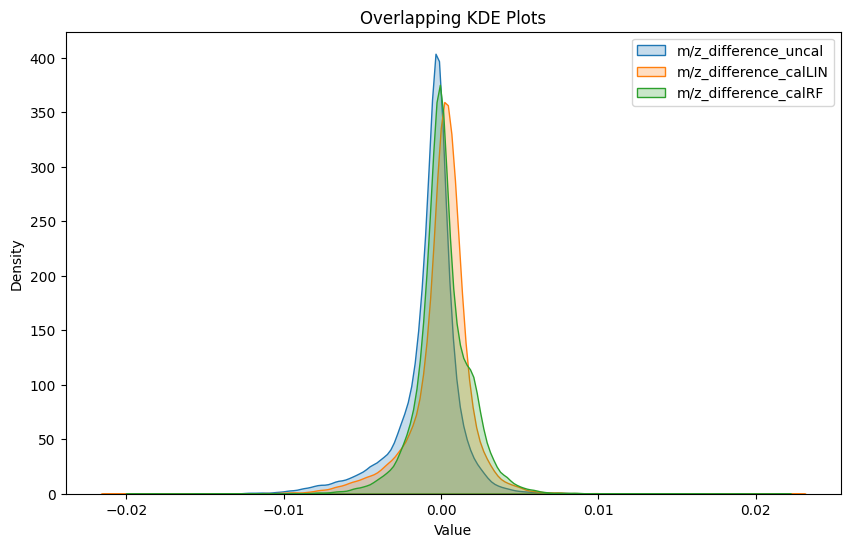

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 6))

columns_to_plot = ['m/z_difference_uncal', 'm/z_difference_calLIN', 'm/z_difference_calRF']

# Loop through each column and create overlapping KDE plots
for column in columns_to_plot:
    sns.kdeplot(filtered_merged_data[column], label=column, shade=True)

# Set title and labels
plt.title('Overlapping KDE Plots')
plt.xlabel('Value')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()

/tmp/ipykernel_2501553/1105376508.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)
/tmp/ipykernel_2501553/1105376508.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)
/tmp/ipykernel_2501553/1105376508.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_merged_data[column], label=column, shade=True)


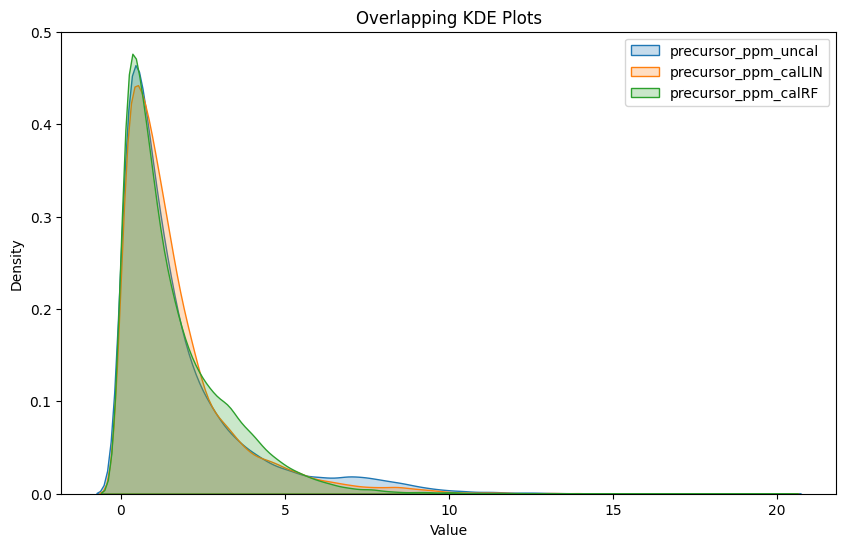

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(10, 6))

columns_to_plot = ['precursor_ppm_uncal', 'precursor_ppm_calLIN', 'precursor_ppm_calRF']

# Loop through each column and create overlapping KDE plots
for column in columns_to_plot:
    sns.kdeplot(filtered_merged_data[column], label=column, shade=True)

# Set title and labels
plt.title('Overlapping KDE Plots')
plt.xlabel('Value')
plt.ylabel('Density')

# Show legend
plt.legend()

# Show plot
plt.show()

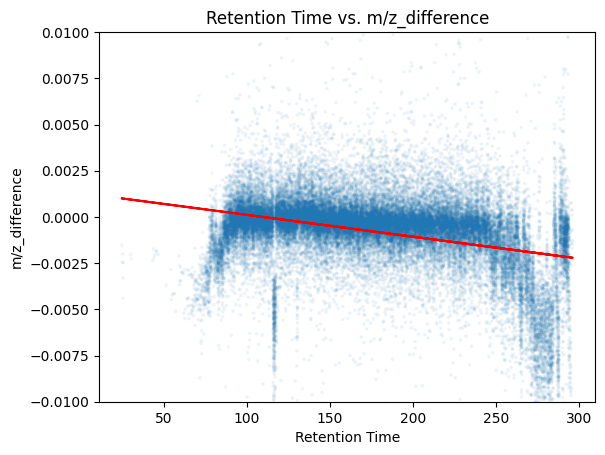

Slope: -1.1812981416629081e-05
Intercept: 0.001291879168543407


In [32]:
import matplotlib.pyplot as plt
import numpy as np
# Scatter plot
plt.scatter(df_Uncal_filtered['rt'], df_Uncal_filtered['m/z_difference'], marker='o', linestyle='', alpha=0.05, s=3)
plt.xlabel('Retention Time')
plt.ylabel('m/z_difference')
plt.title('Retention Time vs. m/z_difference')
plt.ylim(-0.01,0.01)

# Fit a line
x = df_Uncal_filtered['rt']
y = df_Uncal_filtered['m/z_difference']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
plt.plot(x, polynomial(x), color='red')

plt.show()

# Get the coefficients
slope, intercept = coefficients
print("Slope:", slope)
print("Intercept:", intercept)

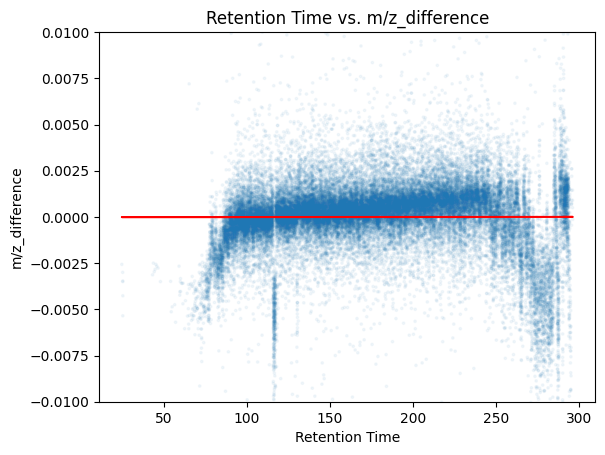

Slope: 3.4585059926926277e-08
Intercept: -9.654588056314207e-06


In [33]:
import matplotlib.pyplot as plt
import numpy as np
# Scatter plot
plt.scatter(df_LINcal_selectedIonMZ_filtered['rt'], df_LINcal_selectedIonMZ_filtered['m/z_difference'], marker='o', linestyle='', alpha=0.05, s=3)
plt.xlabel('Retention Time')
plt.ylabel('m/z_difference')
plt.title('Retention Time vs. m/z_difference')
plt.ylim(-0.01,0.01)

# Fit a line
x = df_LINcal_selectedIonMZ_filtered['rt']
y = df_LINcal_selectedIonMZ_filtered['m/z_difference']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
plt.plot(x, polynomial(x), color='red')

plt.show()

# Get the coefficients
slope, intercept = coefficients
print("Slope:", slope)
print("Intercept:", intercept)

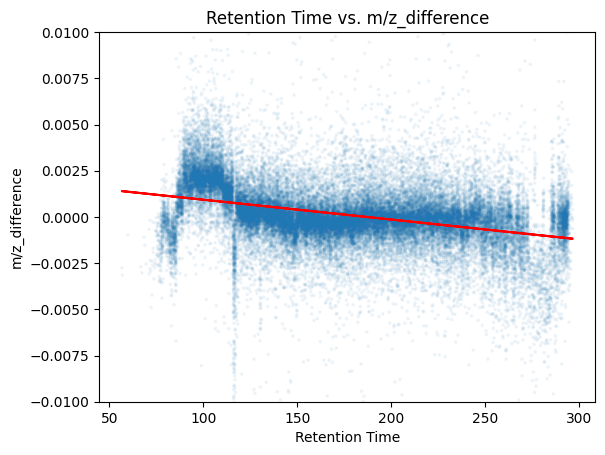

Slope: -1.0744029906524738e-05
Intercept: 0.0020057487311823476


In [36]:
import matplotlib.pyplot as plt
import numpy as np
# Scatter plot
plt.scatter(df_RFcal_selectedIonMZ_filtered['rt'], df_RFcal_selectedIonMZ_filtered['m/z_difference'], marker='o', linestyle='', alpha=0.05, s=3)
plt.xlabel('Retention Time')
plt.ylabel('m/z_difference')
plt.title('Retention Time vs. m/z_difference')
plt.ylim(-0.01,0.01)

# Fit a line
x = df_RFcal_selectedIonMZ_filtered['rt']
y = df_RFcal_selectedIonMZ_filtered['m/z_difference']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
plt.plot(x, polynomial(x), color='red')

plt.show()

# Get the coefficients
slope, intercept = coefficients
print("Slope:", slope)
print("Intercept:", intercept)

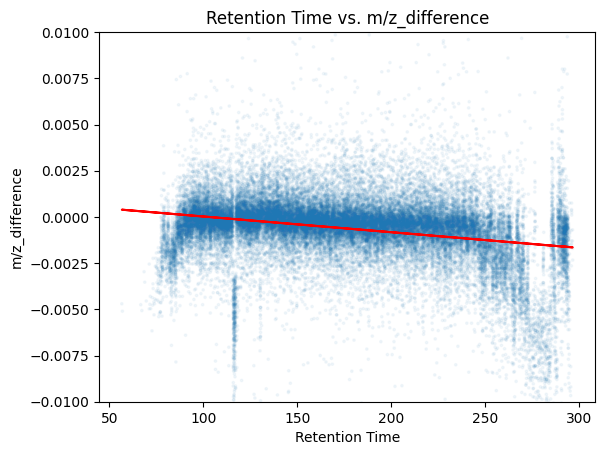

Slope: -8.504079052566483e-06
Intercept: 0.0008733139696691708


In [37]:
import matplotlib.pyplot as plt
import numpy as np
# Scatter plot
plt.scatter(df_RFcal_original_filtered['rt'], df_RFcal_original_filtered['m/z_difference'], marker='o', linestyle='', alpha=0.05, s=3)
plt.xlabel('Retention Time')
plt.ylabel('m/z_difference')
plt.title('Retention Time vs. m/z_difference')
plt.ylim(-0.01,0.01)

# Fit a line
x = df_RFcal_original_filtered['rt']
y = df_RFcal_original_filtered['m/z_difference']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
plt.plot(x, polynomial(x), color='red')

plt.show()

# Get the coefficients
slope, intercept = coefficients
print("Slope:", slope)
print("Intercept:", intercept)

In [12]:
import pandas as pd
data_RF_V2 = "20210120_HM_HEK_IAA_300minGr_R1_RFcal_SelectedIonMZ_V2.tsv"
df_RF_V2 = pd.read_csv(data_RF_V2, sep='\t')
pd.set_option('display.max_columns', None)
df_RF_V2.head(5)
print(df_RF_V2.shape)
df_RF_V2_q = df_RF_V2[df_RF_V2["spectrum_q"] < 0.01]
print(df_RF_V2_q.shape)

(55871, 36)
(44809, 36)


,peptide,proteins,num_proteins,filename,scannr,rank,label,expmass,calcmass,charge,peptide_len,missed_cleavages,isotope_error,precursor_ppm,fragment_ppm,hyperscore,delta_next,delta_best,rt,aligned_rt,predicted_rt,delta_rt_model,matched_peaks,longest_b,longest_y,longest_y_pct,matched_intensity_pct,scored_candidates,poisson,sage_discriminant_score,posterior_error,spectrum_q,peptide_q,protein_q,ms1_intensity,ms2_intensity
0,DLSAAGIGLLAAATQSLSMPASLGR,tr|A0A0R4J2E8|A0A0R4J2E8_HUMAN;tr|A0A1B0GX04|A...,2,20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RFv...,controllerType=0 controllerNumber=1 scan=87181,1,1,2370.2590,2370.2576,2,25,0,0.0,0.618010,5.223156,84.998809,54.519394,0.0,292.91214,0.986236,0.955462,0.030775,28,13,15,0.600000,59.608982,42,-22.121843,2.684541,-324.0,0.000138,0.000247,0.000802,47365012.0,22585296.0
1,GLVAVITGGASGLGLATAER,tr|A0A0S2Z410|A0A0S2Z410_HUMAN;tr|A0A0S2Z434|A...,2,20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RFv...,controllerType=0 controllerNumber=1 scan=59845,1,1,1812.0140,1812.0106,2,20,0,0.0,1.886283,5.130011,74.676914,46.203998,0.0,208.32321,0.701425,0.693104,0.008321,25,7,16,0.800000,58.276936,20,-16.643000,2.643224,-324.0,0.000138,0.000247,0.000802,21973036.0,3841330.5
2,KGADSLEDFLYHEGYAC[+57.0214]TSIHGDR,tr|A0A0J9YVQ7|A0A0J9YVQ7_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RFv...,controllerType=0 controllerNumber=1 scan=38786,1,1,2740.2188,2740.2188,3,24,1,0.0,0.000000,3.708195,77.265699,77.265699,0.0,151.94298,0.511593,0.411428,0.100165,27,6,15,0.625000,51.125770,19,-21.210374,2.635542,-324.0,0.000138,0.000247,0.000802,13877569.0,1224927.0
3,DLSAAGIGLLAAATQSLSMPASLGR,tr|A0A0R4J2E8|A0A0R4J2E8_HUMAN;tr|A0A1B0GX04|A...,2,20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RFv...,controllerType=0 controllerNumber=1 scan=87178,1,1,2370.2598,2370.2576,3,25,0,0.0,0.927015,5.033402,83.516355,50.275417,0.0,292.90800,0.986222,0.955462,0.030761,27,12,15,0.600000,51.559853,48,-20.625909,2.629967,-324.0,0.000138,0.000247,0.000802,118002050.0,39306636.0
4,AQAALQAVNSVQSGNLALAASAAAVDAGMAMAGQSPVLR,tr|A0A087WU68|A0A087WU68_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RFv...,controllerType=0 controllerNumber=1 scan=86106,1,1,3679.8772,3679.8772,3,39,0,0.0,0.000000,5.298624,80.504658,54.530137,0.0,290.11100,0.976805,0.981125,0.004321,27,7,11,0.282051,55.877930,49,-21.492103,2.596509,-324.0,0.000138,0.000247,0.000802,31920462.0,7520791.0


In [13]:
df_RF_V2_q['exp_m/z'] = df_RF_V2_q['expmass'] / df_RF_V2_q['charge']
df_RF_V2_q['calc_m/z'] = df_RF_V2_q['calcmass'] / df_RF_V2_q['charge']
df_RF_V2_q['m/z_difference'] = df_RF_V2_q['calc_m/z'] - df_RF_V2_q['exp_m/z']

/tmp/ipykernel_1488047/180303574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RF_V2_q['exp_m/z'] = df_RF_V2_q['expmass'] / df_RF_V2_q['charge']
/tmp/ipykernel_1488047/180303574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RF_V2_q['calc_m/z'] = df_RF_V2_q['calcmass'] / df_RF_V2_q['charge']
/tmp/ipykernel_1488047/180303574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [14]:
df_RF_V2_q.head(5)

,peptide,proteins,num_proteins,filename,scannr,rank,label,expmass,calcmass,charge,peptide_len,missed_cleavages,isotope_error,precursor_ppm,fragment_ppm,hyperscore,delta_next,delta_best,rt,aligned_rt,predicted_rt,delta_rt_model,matched_peaks,longest_b,longest_y,longest_y_pct,matched_intensity_pct,scored_candidates,poisson,sage_discriminant_score,posterior_error,spectrum_q,peptide_q,protein_q,ms1_intensity,ms2_intensity,exp_m/z,calc_m/z,m/z_difference
0,DLSAAGIGLLAAATQSLSMPASLGR,tr|A0A0R4J2E8|A0A0R4J2E8_HUMAN;tr|A0A1B0GX04|A...,2,20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RFv...,controllerType=0 controllerNumber=1 scan=87181,1,1,2370.2590,2370.2576,2,25,0,0.0,0.618010,5.223156,84.998809,54.519394,0.0,292.91214,0.986236,0.955462,0.030775,28,13,15,0.600000,59.608982,42,-22.121843,2.684541,-324.0,0.000138,0.000247,0.000802,47365012.0,22585296.0,1185.129500,1185.128800,-0.000700
1,GLVAVITGGASGLGLATAER,tr|A0A0S2Z410|A0A0S2Z410_HUMAN;tr|A0A0S2Z434|A...,2,20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RFv...,controllerType=0 controllerNumber=1 scan=59845,1,1,1812.0140,1812.0106,2,20,0,0.0,1.886283,5.130011,74.676914,46.203998,0.0,208.32321,0.701425,0.693104,0.008321,25,7,16,0.800000,58.276936,20,-16.643000,2.643224,-324.0,0.000138,0.000247,0.000802,21973036.0,3841330.5,906.007000,906.005300,-0.001700
2,KGADSLEDFLYHEGYAC[+57.0214]TSIHGDR,tr|A0A0J9YVQ7|A0A0J9YVQ7_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RFv...,controllerType=0 controllerNumber=1 scan=38786,1,1,2740.2188,2740.2188,3,24,1,0.0,0.000000,3.708195,77.265699,77.265699,0.0,151.94298,0.511593,0.411428,0.100165,27,6,15,0.625000,51.125770,19,-21.210374,2.635542,-324.0,0.000138,0.000247,0.000802,13877569.0,1224927.0,913.406267,913.406267,0.000000
3,DLSAAGIGLLAAATQSLSMPASLGR,tr|A0A0R4J2E8|A0A0R4J2E8_HUMAN;tr|A0A1B0GX04|A...,2,20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RFv...,controllerType=0 controllerNumber=1 scan=87178,1,1,2370.2598,2370.2576,3,25,0,0.0,0.927015,5.033402,83.516355,50.275417,0.0,292.90800,0.986222,0.955462,0.030761,27,12,15,0.600000,51.559853,48,-20.625909,2.629967,-324.0,0.000138,0.000247,0.000802,118002050.0,39306636.0,790.086600,790.085867,-0.000733
4,AQAALQAVNSVQSGNLALAASAAAVDAGMAMAGQSPVLR,tr|A0A087WU68|A0A087WU68_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1_Calibrated_RFv...,controllerType=0 controllerNumber=1 scan=86106,1,1,3679.8772,3679.8772,3,39,0,0.0,0.000000,5.298624,80.504658,54.530137,0.0,290.11100,0.976805,0.981125,0.004321,27,7,11,0.282051,55.877930,49,-21.492103,2.596509,-324.0,0.000138,0.000247,0.000802,31920462.0,7520791.0,1226.625733,1226.625733,0.000000


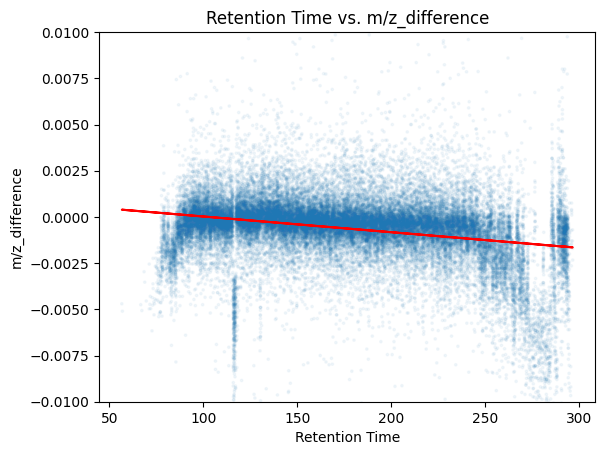

Slope: -8.504079052566483e-06
Intercept: 0.0008733139696691708


In [11]:
import matplotlib.pyplot as plt
import numpy as np
# Scatter plot
plt.scatter(df_RF_V2_q['rt'], df_RF_V2_q['m/z_difference'], marker='o', linestyle='', alpha=0.05, s=3)
plt.xlabel('Retention Time')
plt.ylabel('m/z_difference')
plt.title('Retention Time vs. m/z_difference')
plt.ylim(-0.01,0.01)

# Fit a line
x = df_RF_V2_q['rt']
y = df_RF_V2_q['m/z_difference']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
plt.plot(x, polynomial(x), color='red')

plt.show()

# Get the coefficients
slope, intercept = coefficients
print("Slope:", slope)
print("Intercept:", intercept)